# Pytorch Workflow Fundamentals

In [1]:
what_were_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [6]:
import torch     
from torch import nn # nn contains all of Pytorch's building bloacks for neural network
import matplotlib.pyplot as plt              
import matplotlib

torch.__version__ , matplotlib.__version__

('2.1.1+cu121', '3.8.2')

## 1. Data (preparing and loading) 

In [7]:
# Create *know* parameters 
weight = 0.7 
bias = 0.3 

# Create data 
start = 0 
end = 1 
step = 0.02 

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias 

X[: 10], y[:10]



(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [8]:
# Create train/test split 
train_split = int(0.8 * len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [11]:
(X_train.ndim), (y_train.ndim), (X_test.ndim), (y_test.ndim)

(2, 2, 2, 2)

In [12]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

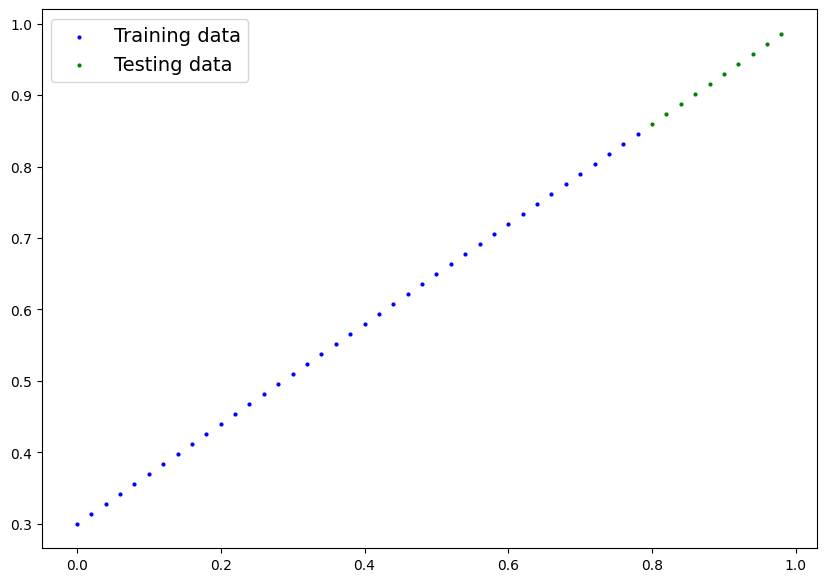

In [13]:
plot_predictions()

## 2. Build model

In [26]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

In [38]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [39]:
# list named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [47]:
# Make predictions with model
with torch.inference_mode(): 
    # y_preds = model_0(1)
    y_preds = model_0(y_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

In [48]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.4184],
        [0.4231],
        [0.4278],
        [0.4325],
        [0.4372],
        [0.4419],
        [0.4466],
        [0.4514],
        [0.4561],
        [0.4608]])


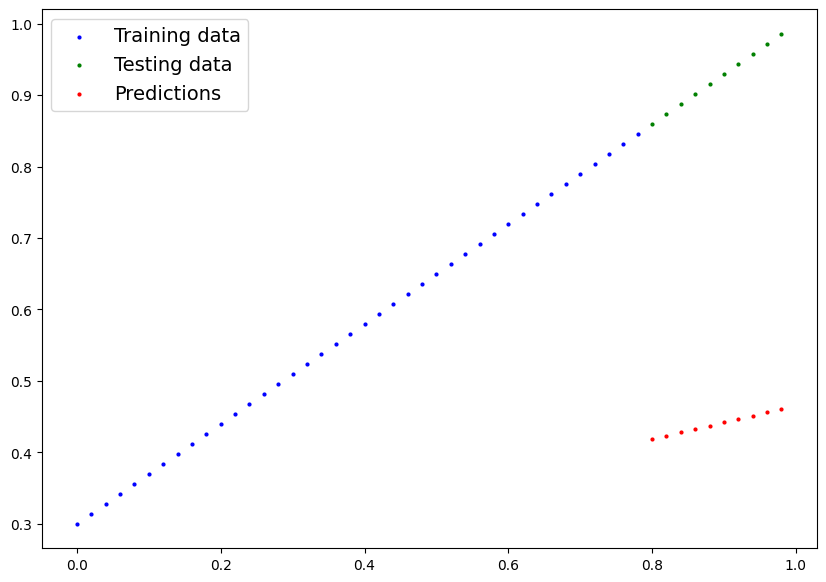

In [49]:
plot_predictions(predictions=y_preds)

In [50]:
y_test - y_preds

tensor([[0.4416],
        [0.4509],
        [0.4602],
        [0.4695],
        [0.4788],
        [0.4881],
        [0.4974],
        [0.5066],
        [0.5159],
        [0.5252]])

## Train model

In [53]:
# Create the loss function
loss_fn = nn.L1Loss()

# Create the optimizer 
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [54]:
torch.manual_seed(42)

# Set the number of epochs (how many the model will pass over the training data)
epochs = 100 

# Create empty loss lists to track values 
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training 
    
    # Put model in training (this is the default state of a model)
    model_0.train()
    
    # 1. Forward paass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)
    
    # 2. Calculate the loss (how diff are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)
    
    # 3. Zero grad of the optimizer
    optimizer.zero_grad()
    
    
    # 4. Loss backwards
    loss.backward()
    
    # 5. Progress the optimizer
    optimizer.step()
    
    ### Testing
    model_0.eval()
    
    with torch.inference_mode():
        # 1. Forward pass on test data
        test_pred = model_0(X_test)
        
        # 2. Calculate loss on test data
        test_loss = loss_fn(test_pred, y_test.type(torch.float))
        
        
        # Print out what's happening
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")
            

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819


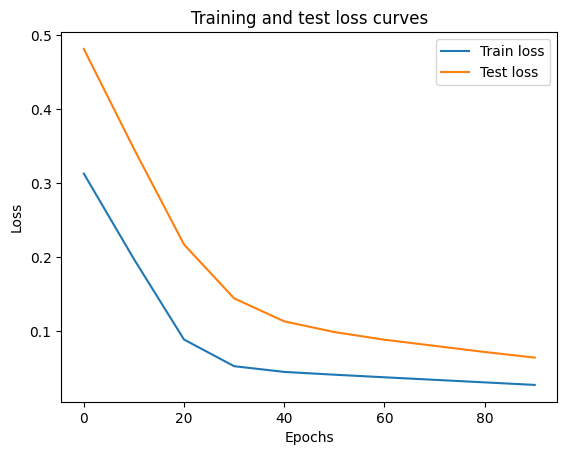

In [55]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [56]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## Making predictions with a trained PyTorch model

In [57]:
# 1. Set the model in eval mode 
model_0.eval()

# 2. Setup the inference mode context manager 
with torch.inference_mode():
    y_preds = model_0(X_test)


y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

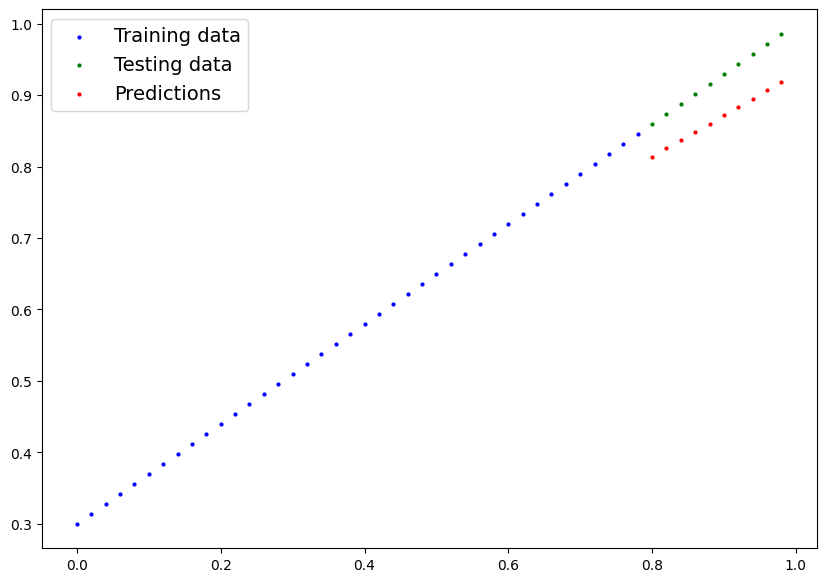

In [58]:
plot_predictions(predictions=y_preds)

## 5. Saving and loading a Pytorch model

In [61]:
from pathlib import Path            

# 1. Create models directory 
MODEL_PATH = Path("custom_models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH} ")
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)



Saving model to: custom_models/01_pytorch_workflow_model_0.pth 


In [62]:
# Check the saved file path
!ls -l custom_models/01_pytorch_workflow_model_0.pth

-rw-rw-r-- 1 acleda acleda 1680 Oct 23 15:04 custom_models/01_pytorch_workflow_model_0.pth


In [64]:
loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))



<All keys matched successfully>

In [66]:
loaded_model_0.eval()

with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)


In [67]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])